# Project 1 -  Text Classification Task

## 1 - Data Provenance and Characteristics

The dataset we will be working with consists of publications sourced from Reddit and Google, authored by individuals from England, Australia, and India. 

The Reddit-sourced data is divided as follows:

- Reddit (England): Training data and test data
- Reddit (Australia): Training data and test data
- Reddit (India): Training data and test data

Similarly, an equivalent division applies to the Google-sourced data:

- Google (England): Training data and test data
- Google (Australia): Training data and test data
- Google (India): Training data and test data

All datasets share the same attributes: `id`, a unique identifier for each entry, `text`, the content of the publication, and `sentiment_label`, the target variable for our analysis. The `sentiment_label` is binary, where `0` indicates a negative sentiment and `1` indicates a positive sentiment.

## 2 - Exploratory Data Analysis

### 2.1 - Initial Setup

We begin by reading all 12 datasets. Since the distinction between training and test data is not relevant for our analysis, we first merge them, reducing the total to 6 datasets.

To further facilitate analysis, we also create 3 additional datasets, grouping the data by country of origin. In this step, we combine Reddit and Google data while keeping separate datasets for England, Australia, and India. Moreover, we also create 3 datasets, grouping the data by their source, whcih is either Reddit or Google.

In the end, we also created a global dataset, that is, with all the data we have available.

In addition, we removed the `id` attribute at the beginning of our process. This decision was made to prevent inconsistencies, as some publications shared the same `id` across different datasets. Keeping this attribute could lead to ambiguity in the data.

It is important to note that for this project, you need to download a file containing pre-trained embeddings. This file was not added directly to the repository due to its size. To download it, click on this [link](https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt), which will redirect you to a dataset available on Kaggle. Please put the file inside the directory `data_prepared`.

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import time
import numpy as np
import math
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec, KeyedVectors

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats

In [118]:
# read Reddit-sourced data 
reddit_uk_train = pd.read_json("data/reddit-uk-train.jsonl", lines=True).drop("id", axis=1)
reddit_in_train = pd.read_json("data/reddit-in-train.jsonl", lines=True).drop("id", axis=1)
reddit_au_train = pd.read_json("data/reddit-au-train.jsonl", lines=True).drop("id", axis=1)
reddit_uk_valid = pd.read_json("data/reddit-uk-valid.jsonl", lines=True).drop("id", axis=1)
reddit_in_valid = pd.read_json("data/reddit-in-valid.jsonl", lines=True).drop("id", axis=1)
reddit_au_valid = pd.read_json("data/reddit-au-valid.jsonl", lines=True).drop("id", axis=1)

# read Google-sourced data 
google_uk_train = pd.read_json("data/google-uk-train.jsonl", lines=True).drop("id", axis=1)
google_in_train = pd.read_json("data/google-in-train.jsonl", lines=True).drop("id", axis=1)
google_au_train = pd.read_json("data/google-au-train.jsonl", lines=True).drop("id", axis=1)
google_uk_valid = pd.read_json("data/google-uk-valid.jsonl", lines=True).drop("id", axis=1)
google_in_valid = pd.read_json("data/google-in-valid.jsonl", lines=True).drop("id", axis=1)
google_au_valid = pd.read_json("data/google-au-valid.jsonl", lines=True).drop("id", axis=1)

# merge Reddit-sourced data by country
reddit_uk_union = pd.concat([reddit_uk_train, reddit_uk_valid], ignore_index=True)
reddit_au_union = pd.concat([reddit_au_train, reddit_au_valid], ignore_index=True)
reddit_in_union = pd.concat([reddit_in_train, reddit_in_valid], ignore_index=True)

# merge Google-sourced data by country
google_uk_union = pd.concat([google_uk_train, google_uk_valid], ignore_index=True)
google_au_union = pd.concat([google_au_train, google_au_valid], ignore_index=True)
google_in_union = pd.concat([google_in_train, google_in_valid], ignore_index=True)

# merge data by country
uk_union = pd.concat([reddit_uk_union, google_uk_union], ignore_index=True)
au_union = pd.concat([reddit_au_union, google_au_union], ignore_index=True)
in_union = pd.concat([reddit_in_union, google_in_union], ignore_index=True)

# merge data by source
reddit_union = pd.concat([reddit_uk_union, reddit_au_union, reddit_in_union], ignore_index=True)
google_union = pd.concat([google_uk_union, google_au_union, google_in_union], ignore_index=True)

# merge all data
global_union = pd.concat([reddit_union, google_union]).reset_index(drop=True)

In [119]:
def plot_pie_chart(values, labels, title="Pie Chart"):
    plt.figure(figsize=(2 * len(values), len(values)))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)   
    plt.title(title)    
    plt.show()

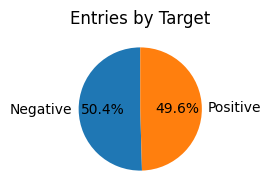

In [120]:
plot_pie_chart([len(global_union[global_union["sentiment_label"] == 0]), len(global_union[global_union["sentiment_label"] == 1])], ["Negative", "Positive"], title="Entries by Target")

### 2.2 - Class Distribution by Source

We began by comparing the number of entries from Reddit and Google. Our analysis shows that both sources contain approximately the same number of entries.

Next, we analyzed the distribution of the sentiment class in both sources. This analysis revealed that Reddit data is predominantly negative, while Google data is mostly positive.

From Reddit there are 5064 entries
From Google there are 5014 entries


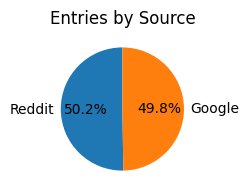

In [121]:
print("From Reddit there are " + str(len(reddit_union)) + " entries")
print("From Google there are " + str(len(google_union)) + " entries")
plot_pie_chart([len(reddit_union), len(google_union)], ["Reddit", "Google"], title="Entries by Source")

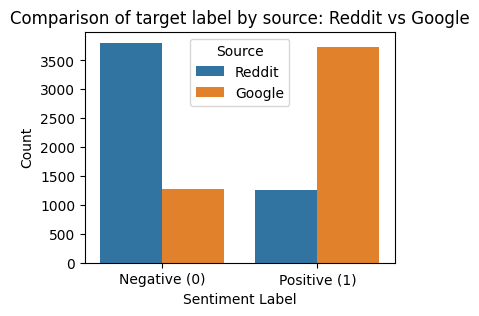

In [122]:
# count distribuition of the target class by source
reddit_counts = reddit_union["sentiment_label"].value_counts().reset_index()
google_counts = google_union["sentiment_label"].value_counts().reset_index()

# create dataframe
reddit_counts.columns = ["sentiment_label", "Reddit"]
google_counts.columns = ["sentiment_label", "Google"]
df = pd.merge(reddit_counts, google_counts, on="sentiment_label", how="outer")
df_melted = df.melt(id_vars="sentiment_label", var_name="Source", value_name="Count")

# create graph
plt.figure(figsize=(4,3))
sns.barplot(data=df_melted, x="sentiment_label", y="Count", hue="Source", palette=["#1f77b4", "#ff7f0e"])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Comparison of target label by source: Reddit vs Google")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])
plt.legend(title="Source")
plt.show()

### 2.3 - Class Distribution by Country

Similarly to the source analysis, we also examined the distribution of the data across countries, as well as the balance of the target class distribution.

As shown below, the datasets have roughly the same number of entries, and the target class is approximately evenly distributed.

From UK there are 3210 entries
From AU there are 3080 entries
From IN there are 3788 entries


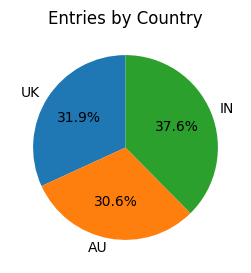

In [123]:
print("From UK there are " + str(len(uk_union)) + " entries")
print("From AU there are " + str(len(au_union)) + " entries")
print("From IN there are " + str(len(in_union)) + " entries")
plot_pie_chart([len(uk_union), len(au_union), len(in_union)], ["UK", "AU", "IN"], title="Entries by Country")


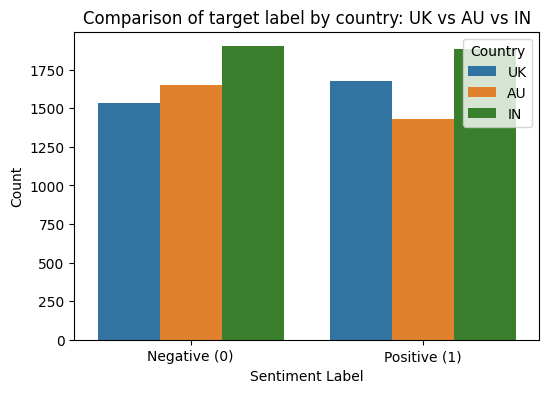

In [124]:
# count distribuition of the target class by country
uk_counts = uk_union["sentiment_label"].value_counts().reset_index()
au_counts = au_union["sentiment_label"].value_counts().reset_index()
in_counts = in_union["sentiment_label"].value_counts().reset_index()

# create dataframe
uk_counts.columns = ["sentiment_label", "UK"]
au_counts.columns = ["sentiment_label", "AU"]
in_counts.columns = ["sentiment_label", "IN"]
df_counts = pd.merge(uk_counts, au_counts, on="sentiment_label", how="outer")
df_counts = pd.merge(df_counts, in_counts, on="sentiment_label", how="outer")
df_melted = df_counts.melt(id_vars="sentiment_label", var_name="Country", value_name="Count")

# create graph
plt.figure(figsize=(6,4))
sns.barplot(data=df_melted, x="sentiment_label", y="Count", hue="Country", palette=["#1f77b4", "#ff7f0e", "#2f8c1f"])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Comparison of target label by country: UK vs AU vs IN")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])
plt.legend(title="Country")
plt.show()

### 2.4 - Word Distribution by Source

Next, we analyzed the distribution of words by source, focusing on the top 10 words. As shown, despite the words appearing in different positions across the sources, there are 3 common words. This low number may be due to the topic of the posts, which can be very different between platforms.

In [125]:
# function to calculate and plot TF-IDF
def plot_tfidf(dataset, title):
    
    # get text column
    texts = dataset["text"]  
    
    # start TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = vectorizer.fit_transform(texts)   
    terms = vectorizer.get_feature_names_out()   
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)   
    sum_tfidf = tfidf_df.sum(axis=0)   
    sorted_tfidf = sum_tfidf.sort_values(ascending=False)
    
    # plot graph
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_tfidf)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    return sorted_tfidf.head(10).index.tolist()

def plot_wordcolud(dataset):
    wordcloud = WordCloud().generate(" ".join(dataset["text"].dropna().astype(str)))
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

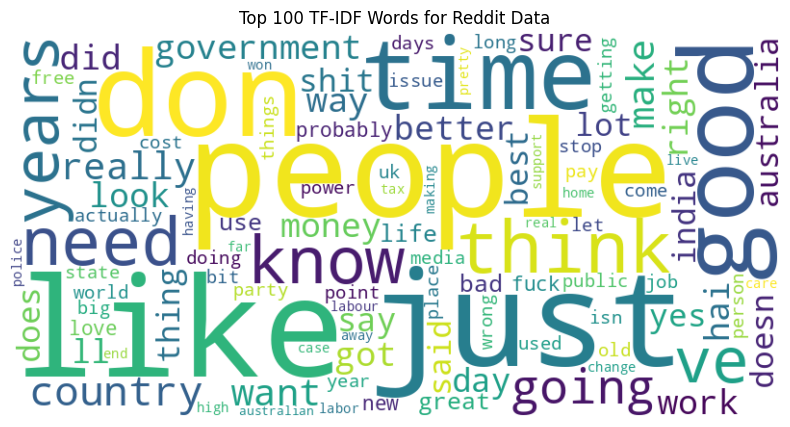

In [126]:
reddit_top = plot_tfidf(reddit_union, 'Top 100 TF-IDF Words for Reddit Data')

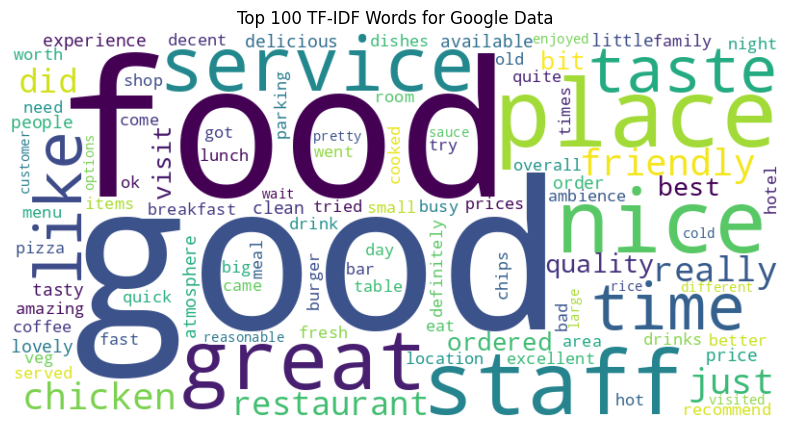

In [127]:
google_top = plot_tfidf(google_union, 'Top 100 TF-IDF Words for Google Data')

In [128]:
comumn_top = list(set(reddit_top) & set(google_top))

print("There are " + str(len(comumn_top)) + " common words.")
print("They are : " + str(comumn_top))

There are 3 common words.
They are : ['good', 'time', 'like']


### 2.5 - Word Distribution by Country

We also analyzed the distribution of words by country. As shown, the vocabulary does not seem to vary significantly across countries, as the number of common words between two datasets ranges from 7 to 8 out of 10.

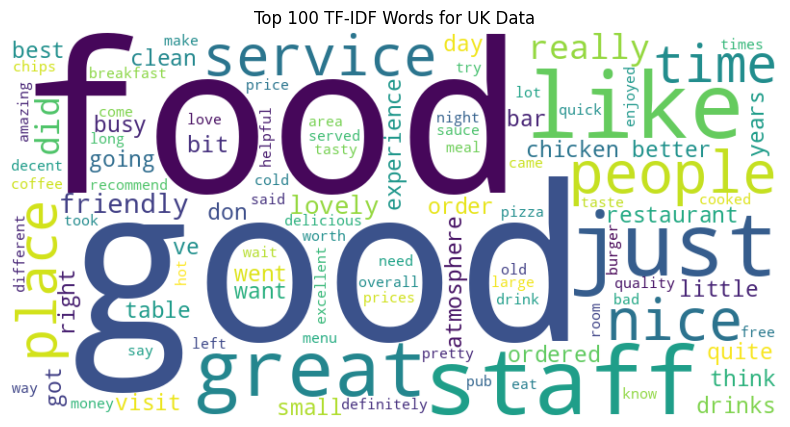

In [129]:
uk_top = plot_tfidf(uk_union, 'Top 100 TF-IDF Words for UK Data')

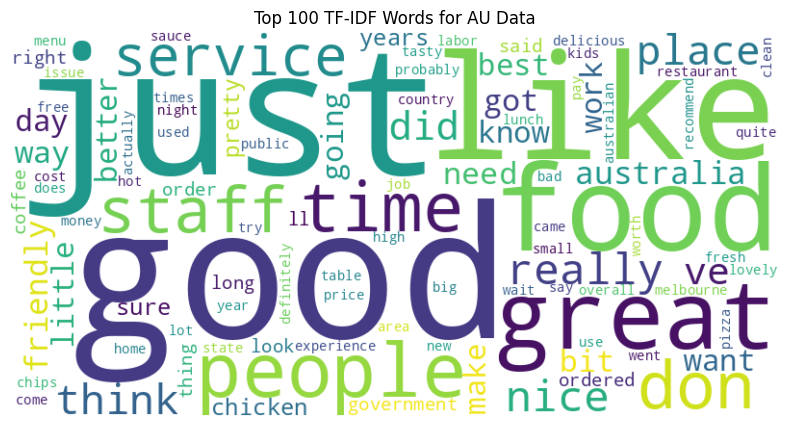

In [130]:
au_top = plot_tfidf(au_union, 'Top 100 TF-IDF Words for AU Data')

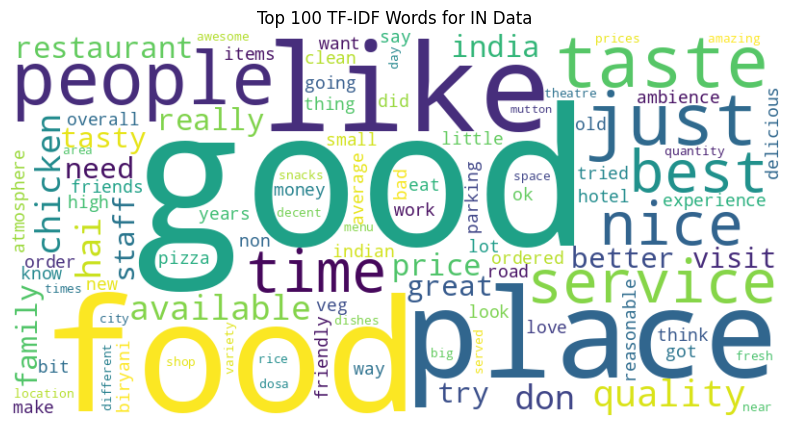

In [131]:
in_top = plot_tfidf(in_union, 'Top 100 TF-IDF Words for IN Data')

In [132]:
comumn_uk_au_top = list(set(uk_top) & set(au_top))
comumn_au_in_top = list(set(au_top) & set(in_top))
comumn_in_uk_top = list(set(in_top) & set(uk_top))

print("UK and AU")
print("There are " + str(len(comumn_uk_au_top)) + " common words.")
print("They are : " + str(comumn_uk_au_top))

print("\nAU and IN")
print("There are " + str(len(comumn_au_in_top)) + " common words.")
print("They are : " + str(comumn_au_in_top))

print("\nIN and UK")
print("There are " + str(len(comumn_in_uk_top)) + " common words.")
print("They are : " + str(comumn_in_uk_top))

UK and AU
There are 8 common words.
They are : ['great', 'like', 'staff', 'just', 'food', 'good', 'people', 'service']

AU and IN
There are 7 common words.
They are : ['time', 'like', 'just', 'food', 'good', 'people', 'service']

IN and UK
There are 8 common words.
They are : ['like', 'place', 'nice', 'just', 'food', 'good', 'people', 'service']


## 3 - Data Pre-Processing

In this step, we remove all characters that are not alphabetical or whitespace. Additionally, we convert the text to lowercase and eliminate consecutive spaces. After cleaning the text, we perform tokenization and lemmazation. Finally, we remove words from the stopwords list, except for those with negation, as they are crucial for our classification task.

We initially experimented with stemming as an alternative to lemmatization but ultimately chose the latter. At first, our lemmatization approach did not account for a word’s context, leading to incorrect results. Upon further investigation, we discovered the importance of specifying the `pos` parameter in the "lemmatize" function, which determines whether a word is a verb, noun, adjective, or adverb. To ensure accurate classification, we leveraged the `pos_tag` function from `NLTK` to assign the appropriate part of speech before lemmatization.

In [133]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words_remove = {"no", "not", "nor", "t"}
stop_words.difference_update(stop_words_remove)

lemma = nltk.WordNetLemmatizer()
token = nltk.word_tokenize

def lemmatize_with_pos(text):
    words = token(text)   
    words_tag = nltk.pos_tag(words)   
    words_lem = []
    for word, tag in words_tag:
        if tag.startswith('N'): words_lem.append(lemma.lemmatize(word, pos='n')) # noun
        elif tag.startswith('V'): words_lem.append(lemma.lemmatize(word, pos='v')) # verb
        elif tag.startswith('J'): words_lem.append(lemma.lemmatize(word, pos='a')) # adjective
        elif tag.startswith('R'): words_lem.append(lemma.lemmatize(word, pos='r')) # adverb
        else: words_lem.append(lemma.lemmatize(word))
    return words_lem

def text_pre_processing(dataset):
    # text_vader
    dataset['text_vader'] = dataset['text'].apply(contractions.fix)
    dataset['text_vader'] = dataset["text_vader"].apply(lambda x: re.sub(r'[^\x00-\x7F]|[^a-zA-Z ]', ' ', x).strip()) # remove all the caracteres that do not belong to the alphabet and are not a whitespace
    dataset["text_vader"] = dataset["text_vader"].apply(str.lower) # converte all caracteres to lowercase
    dataset["text_vader"] = dataset["text_vader"].apply(lambda x: re.sub(r'\s+', ' ', x).strip()) # remove multiple whitespaces  
    # text_processed
    dataset['text_processed'] = dataset['text_vader'].apply(token) # apply tokenization    
    dataset['text_processed'] = dataset['text_processed'].apply(lambda x: [word for word in x if word not in stop_words]) # remove stopwords, mantaining words like 'no', 'not', 'nor', 't'
    # # # apply stemization
    # # dataset['text_processed'] = dataset['text_processed'].apply(lambda x: [nltk.PorterStemmer().stem(w) for w in x])    
    dataset['text_processed'] = dataset['text_processed'].apply(lambda x: lemmatize_with_pos(" ".join(x))) # apply lemmazation   
    dataset['text_processed'] = [" ".join(text) for text in dataset["text_processed"]] # join words from the list in a sentence    
    return dataset
       
def metrics(y_test, y_pred, time):
    [[tn, fp], [fn, tp]] = (confusion_matrix(y_test, y_pred))    
    print("                    predicted negative   predicted positive")
    print("real negative       " + str(tn) + (" " * (len(str(fn)) - 1)) + "                " + str(fp))
    print("real positive       " + str(fn) + (" " * (len(str(tn)) - 1)) + "                " + str(tp))
    print(f"\nAccuracy {accuracy_score(y_test, y_pred):.2f} Precision {precision_score(y_test, y_pred):.2f} Recall {recall_score(y_test, y_pred):.2f} F1 Score {f1_score(y_test, y_pred):.2f} Time {time:.2f}") 

text_pre_processing(global_union)
text_pre_processing(uk_union)
text_pre_processing(au_union)
text_pre_processing(in_union)

[nltk_data] Downloading package stopwords to /home/manu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/manu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/manu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/manu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/manu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,sentiment_label,text_vader,text_processed
0,Zepto has a mandate that the delivery boy need...,1,zepto has a mandate that the delivery boy need...,zepto mandate delivery boy need click picture ...
1,Mujhe bhi thoda paisa do,0,mujhe bhi thoda paisa do,mujhe bhi thoda paisa
2,Nooo don't protest against secular freedom fig...,0,nooo do not protest against secular freedom fi...,nooo not protest secular freedom fighter owais...
3,Har 3 mahine baad kisi bhi global celebrity ko...,0,har mahine baad kisi bhi global celebrity ko b...,har mahine baad kisi bhi global celebrity ko b...
4,Just because you don't find anything serious b...,0,just because you do not find anything serious ...,not find anything serious not mean nothing gir...
...,...,...,...,...
3783,It was ok. Chef need to bring taste in food. J...,0,it was ok chef need to bring taste in food jus...,ok chef need bring taste food ok type restaura...
3784,Food is best for middle class people here. All...,1,food is best for middle class people here all ...,food best middle class people item give quanti...
3785,I think cinema hall is better and full air con...,1,i think cinema hall is better and full air con...,think cinema hall well full air condition soun...
3786,The cafe looks good and we can celebrate birth...,1,the cafe looks good and we can celebrate birth...,cafe look good celebrate birthday food taste a...


After making these modifications, we checked for words that were not recognized in `NLTK`'s vocabulary, which likely indicated spelling errors. We attempted to use libraries like `TextBlob` to correct these mistakes but ultimately decided against it due to the high processing time.

We then deleted the entries that had an empty `text_processed`  attribute. This could happen due to pre-processing, for example, if the text attribute only consisted of characters that did not belong to the alphabet.

After we have made these modifications to the datasets, we save them to our repository.

In [134]:
nltk.download('words')

valid_words = set(nltk.corpus.words.words())
invalid_words = set()
invalid_entries = set()

corpus = global_union["text_processed"].dropna().astype(str).tolist()
for idx, comment in enumerate(corpus):
    words = comment.split()
    for word in words:
        if word not in valid_words:
            invalid_words.add(word)
            invalid_entries.add(idx)

print("There are " + str(len(invalid_entries)) + " entries with invalid words")
print("The words are " + str(invalid_words))

print("\nRemoval empty entries:")
print("- Before we had " + str(len(global_union)) + " entries.")
global_union = global_union[global_union["text_processed"].str.len() > 0]
print("- Now we have " + str(len(global_union)) + " entries.")

folder_path = "data_prepared"
os.makedirs(folder_path, exist_ok=True)
global_union.to_csv(os.path.join(folder_path, "global_union.csv"), index=False, encoding="utf-8")

[nltk_data] Downloading package words to /home/manu/nltk_data...
[nltk_data]   Package words is already up-to-date!


There are 7642 entries with invalid words
The words are {'cu', 'expats', 'pel', 'nigeria', 'hobedtly', 'sayin', 'pallas', 'choi', 'buttie', 'darpokdictator', 'aunti', 'desalination', 'davey', 'yarra', 'lowys', 'chingri', 'peppes', 'bagga', 'burj', 'diddly', 'towels', 'thande', 'michelle', 'neyychoru', 'amanda', 'radiohead', 'gastro', 'tqftbzacnuj', 'drilled', 'laaapataa', 'matar', 'dalgona', 'weekdays', 'lattes', 'megaplex', 'mangement', 'pissed', 'bothered', 'gadag', 'yummm', 'oon', 'iits', 'bloomberg', 'steakout', 'cali', 'bekari', 'copius', 'aslo', 'bxtl', 'blackhorse', 'hella', 'karen', 'destablise', 'drumsticks', 'nazification', 'uthega', 'clunky', 'frm', 'badne', 'portfilters', 'talassery', 'arenas', 'sealioning', 'chori', 'perrett', 'hungover', 'que', 'cheriya', 'scumbag', 'typcial', 'judy', 'mangalore', 'mm', 'belfast', 'mafia', 'seeraga', 'chutni', 'mvp', 'creedence', 'arbaaz', 'napkins', 'brexit', 'tottenham', 'mayo', 'bhoi', 'vbhcwbvsabtjevdyy', 'discussing', 'suprise', 'fil

## 4. Feature Representation Technique
Subsequently, we applied a range of feature representation techniques, exploring both sparse and dense vector approaches, as well as `Vader`, that is a sentiment analysis tool.

We also analyze the characteristics of our `text_processed` attribute in relation to its length. Notably, the size ranges from a minimum of 1 to a maximum of 770, indicating a significant variation. Additionally, when examining the mean and mode, we observe that most entries have relatively short lengths.

This information is particularly relevant for our embedding process, as we employ two different techniques: one that concatenates the embeddings of the first 10 words and another that computes the average embedding of all words in the text.

In [135]:
corpus = global_union["text_processed"].dropna().astype(str).tolist()
lens = [len(c.split()) for c in corpus]
print("Text Processed's characteristic:")
print(np.min(lens), np.max(lens), np.mean(lens), np.std(lens), stats.mode(lens))

Text Processed's characteristic:
1 770 26.99404525605399 31.522347005418055 ModeResult(mode=7, count=350)


### 4.1. Sparse Vectors
In relation to sparse vectors:

- **CountVectorizer**: the text is converted into a "bag of words" (BoW), where the order of the words is not considered. The focus is solely on how many times each word appears in the document, without taking into account the sequence or context in which it occurs.

- **TfidfVectorizer**: is similar to CountVectorizer, but with an important difference: it adjusts the word counts by considering not only the frequency of a word in a specific text but also its relative importance in the larger set of documents.

- **ngram_range in TfidfVectorizer**: the `ngram_range` parameter in `TfidfVectorizer` allows the model to capture `n-grams`. By setting `ngram_range` to `(1,2)`, the model will consider both unigrams (individual words) and bigrams (pairs of consecutive words), allowing it to capture more contextual information between nearby words.

In [136]:
print("Representation with sparse vectors:\n")

vectorizer = CountVectorizer(stop_words=None)
x_CountVectorizer = vectorizer.fit_transform(corpus)
print("  - CountVectorizer's shape is " + str(x_CountVectorizer.shape))

vectorizer = TfidfVectorizer(stop_words=None)
x_TfidfVectorizer = vectorizer.fit_transform(corpus)
print("  - TfidfVectorizer's shape is " + str(x_TfidfVectorizer.shape))

vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(1,2)) # unigram and bigram
x_TfidfVectorizerUB = vectorizer.fit_transform(corpus)
print("  - TfidfVectorizerUB's shape is" + str(x_TfidfVectorizerUB.shape))

vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(2,2)) # bigram
x_TfidfVectorizerB = vectorizer.fit_transform(corpus)
print("  - TfidfVectorizerB's shape is " + str(x_TfidfVectorizerB.shape))

Representation with sparse vectors:

  - CountVectorizer's shape is (10076, 19683)
  - TfidfVectorizer's shape is (10076, 19683)
  - TfidfVectorizerUB's shape is(10076, 205010)
  - TfidfVectorizerB's shape is (10076, 185327)


### 4.2. Dense Vectors
Regarding embeddings, we followed two different approaches. In one, we created our own embeddings from our dataset, while in the other, we loaded a pre-trained embeddings file. Additionally, we used different methods to generate sentence embeddings: in one, we concatenated the word vectors, and in the other, we computed their average.

In [137]:
print("Representation with dense vectors:\n")

def text_to_vector(embeddings, text, sequence_len, mode="concat"):
    tokens = text.split()
    vec = []
    vectors = []
    n = 0
    i = 0
    vector_size = embeddings.vector_size

    while i < len(tokens) and n < sequence_len:
        try:
            word_vector = embeddings.get_vector(tokens[i])
            vec.extend(word_vector)
            vectors.append(word_vector)
            n += 1
        except KeyError:
            pass
        finally: 
            i += 1

    if mode == "concat":
        vec.extend(np.zeros(vector_size * (sequence_len - n)))
        return vec
    
    elif mode == "avg":
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(vector_size)

model = Word2Vec([x.split() for x in corpus], vector_size=100, window=3, min_count=2, workers=10, sg=1)
word_vectors_corpus = model.wv
word_vectors_glovef = KeyedVectors.load_word2vec_format("data_prepared/glove.6B.100d.txt", no_header=True, binary=False)

embeddings_corpus_cat = []
embeddings_glovef_cat = []
embeddings_corpus_avg = []
embeddings_glovef_avg = []

for c in corpus:
    embeddings_corpus_cat.append(text_to_vector(word_vectors_corpus, c, 10))
    embeddings_glovef_cat.append(text_to_vector(word_vectors_glovef, c, 10))
    embeddings_corpus_avg.append(text_to_vector(word_vectors_corpus, c, 770, "avg"))
    embeddings_glovef_avg.append(text_to_vector(word_vectors_glovef, c, 770, "avg"))

x_CorpusCat= np.array(embeddings_corpus_cat)
x_CorpusAvg= np.array(embeddings_corpus_avg)
print("  - CorpusCat's shape is " + str(x_CorpusCat.shape))
print("  - CorpusAvg's shape is " + str(x_CorpusAvg.shape))

x_FGloveCat = np.array(embeddings_glovef_cat)
x_FGloveAvg = np.array(embeddings_glovef_avg)
print("  - FGloveCat's shape is " + str(x_FGloveCat.shape))
print("  - FGloveAvg's shape is " + str(x_FGloveAvg.shape))

Representation with dense vectors:

  - CorpusCat's shape is (10076, 1000)
  - CorpusAvg's shape is (10076, 100)
  - FGloveCat's shape is (10076, 1000)
  - FGloveAvg's shape is (10076, 100)


### 4.3. Vader
We also utilize **VADER**, implementing two different approaches. The first, a simpler approach, calculates the polarity of each word and classifies it as positive or negative. The second, a more complex approach, is an algorithm inspired by the professor's slides, which considers additional factors beyond polarity.

The simpler version allows us to immediately predict whether a sentiment is positive or negative. It directly calculates the polarity of a text, considering it positive if its polarity is greater than 0 and negative otherwise. However, as observed, the results do not seem very promising.  

Due to this, we decided to develop an improved algorithm, that also leverages **VADER**, to achieve better results. To do so, we followed an example algorithm provided by our professor. Instead of calculating the polarity of an entire sentence, this approach counts the number of positive and negative words. Additionally, it considers other factors, such as the presence of words like "no" and "not", as well as the number of pronouns. The features extracted from this algorithm will later be used for sentiment prediction through classifiers.

In [138]:
sia = SentimentIntensityAnalyzer()
y_pred = []

X_train, X_test, y_train, y_test = train_test_split(global_union['text_processed'], global_union['sentiment_label'], test_size = 0.20, random_state=42)

start_time = time.time()
for comment in X_test:
    y_pred.append(1 if sia.polarity_scores(comment)['compound'] > 0 else 0)
end_time = time.time()

metrics(y_test, y_pred, end_time - start_time)

                    predicted negative   predicted positive
real negative       573                 448
real positive       99                  896

Accuracy 0.73 Precision 0.67 Recall 0.90 F1 Score 0.77 Time 0.34


In [139]:
from sklearn.discriminant_analysis import StandardScaler


x1_list, x2_list, x3_list, x4_list, x5_list, x6_list = [], [], [], [], [], []
word_info = dict()
pronouns = {"i", "me", "my", "mine", "we", "us", "our", "ours", "you", "your", "yours"}

for line in global_union["text_vader"]:
    words = line.split()
    x1, x2 = 0, 0
    for word in words:
        
        # if word was already checked
        if word in word_info:
            if word_info[word] == 1: x1 += 1
            elif word_info[word] == -1: x2 += 1
            
        # if not calculate polarity and add to the dictionary
        else:
            neg_polarity = sia.polarity_scores(word)["neg"]
            pos_polarity = sia.polarity_scores(word)["pos"]
            cpd_polarity = sia.polarity_scores(word)["compound"]
            if cpd_polarity > 0.05 and pos_polarity > neg_polarity:
                word_info[word] = 1
                x1 += 1
            elif cpd_polarity < -0.05 and pos_polarity < neg_polarity:
                word_info[word] = -1
                x2 += 1
            else:
                word_info[word] = 0
    
    x1_list.append(x1)
    x2_list.append(x2)
    x3_list.append(1 if "no" or "not" in words else 0)
    x4_list.append(sum(1 for word in words if word in pronouns))
    x5_list.append(1 if "!" in words else 0)
    x6_list.append(math.log(len(words) + 1))

df_temp = global_union.copy()
df_temp["x1"] = x1_list # number of positive words
df_temp["x2"] = x2_list # number of negative words
df_temp["x3"] = x3_list # 1 if "no" is present and 0 otherwise
df_temp["x4"] = x4_list # number of pronouns
# df_temp["x5"] = x5_list # 1 if "!" is present and 0 otherwise
df_temp["x6"] = x6_list # logarithm of text length for normalization.

global_union = df_temp
    
# x_vader = global_union[["x1", "x2", "x3", "x4", "x5", "x6"]]
x_vader = global_union[["x1", "x2", "x3", "x4", "x6"]]
scaler = StandardScaler()
x_vader = scaler.fit_transform(x_vader)

## 5. Algorithms

In [140]:
parameters = {
    'LogisticRegression': [
        {
            'penalty': ['l2'],
            'solver': ['lbfgs'],
            'max_iter': [750, 1125, 1500],
        },
        {
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'max_iter': [750, 1125, 1500],
        },
        {
            'penalty': ['l1', 'l2'],
            'solver': ['saga'],
            'max_iter': [750, 1125, 1500],
        },
        {
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'max_iter': [750, 1125, 1500],
            'l1_ratio': [0.25, 0.5, 0.75],
        },
    ],
    'SGDClassifier': [
        {
            'loss': ['hinge'],
            'penalty': ['l1', 'l2'],
            'learning_rate': ['constant', 'optimal', 'invscaling'],
            'eta0': [0.001, 0.01],
        },
        {
            'loss': ['hinge'],
            'penalty': ['elasticnet'],
            'learning_rate': ['constant', 'optimal', 'invscaling'],
            'l1_ratio': [0.25, 0.5, 0.75],
            'eta0': [0.001, 0.01],
        },

        {
            'loss': ['log_loss'],
            'penalty': ['l2'],
            'learning_rate': ['constant', 'invscaling'],
            'eta0': [0.001, 0.01],
        },
        {
            'loss': ['log_loss'],
            'penalty': ['elasticnet'],
            'learning_rate': ['constant', 'invscaling'],
            'l1_ratio': [0.25, 0.5, 0.75],
            'eta0': [0.001, 0.01],
        }
    ]
}

def parameter_tuning(clf, x_predict, y_predict):
    grid_search = GridSearchCV(clf, parameters[str(clf.__class__.__name__)], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(x_predict, y_predict)
    return grid_search.best_estimator_, grid_search.best_params_

def predict_nb(x, y):
    # split dataset and define classifier
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42)
    clf = MultinomialNB()
    # training
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    # testing
    y_pred = clf.predict(X_test)
    metrics(y_test, y_pred, end_time - start_time)
    return X_test, y_test, y_pred

def predict_log(x, y):
    # split dataset and define classifier
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42)
    clf = LogisticRegression(tol=1e-2)
    # parameter tunning and training 
    model, param = parameter_tuning(clf, X_train, y_train)
    start_time = time.time()   
    model.fit(X_train, y_train)
    end_time = time.time()
    # testing
    print(f"\nBets parameters: {param}")
    y_pred = model.predict(X_test)
    metrics(y_test, y_pred, end_time - start_time)
    return X_test, y_test, y_pred
    
def predict_sgd(x, y):
    index = global_union.index
    # split dataset and define classifier
    X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(x, y, index, test_size = 0.20, random_state=42)
    clf = SGDClassifier(tol=1e-2)
    # parameter tunning and training 
    model, param = parameter_tuning(clf, X_train, y_train)
    start_time = time.time()   
    model.fit(X_train, y_train)
    end_time = time.time()
    # testing
    print(f"\nBets parameters: {param}")
    y_pred = model.predict(X_test)
    metrics(y_test, y_pred, end_time - start_time)
    return X_test, y_test, y_pred, index_test, model

### 5.1 Baseline

Initially, we developed a baseline model where the text was not subjected to any preprocessing, and the feature representation was based on a **One Hot Encoder** approach. For classification, we utilized the **Multinomial Naive Bayes** (MultinomialNB) algorithm.

Comparing the size of the feature space in our baseline model, which utilizes raw text without any preprocessing, we observe that it is significantly larger than the feature space of the preprocessed text. Specifically, the baseline model results in **29,4548 features**, whereas the preprocessed text yields **19,683 features**.

In [141]:
vectorizer = CountVectorizer(stop_words=None, lowercase=False, binary=True)
x_baseline = vectorizer.fit_transform(global_union['text'].dropna().astype(str).tolist())
print("Baseline - " + str(x_baseline.shape))
_, _, _ = predict_nb(x_baseline, global_union['sentiment_label'])

Baseline - (10076, 29458)
                    predicted negative   predicted positive
real negative       809                  212
real positive       171                  824

Accuracy 0.81 Precision 0.80 Recall 0.83 F1 Score 0.81 Time 0.00


### 5.2. Multinomial Naive Bayes

Comparing the results obtained with the preprocessed text to those of the baseline model, we observe that the differences in error rates are minimal.

We can also observe that, regarding the use of `n-grams`, the model utilizing only `bigrams` yields the poorest results. In contrast, the model that combines `unigrams` and `bigrams` achieves better performance. This approach strikes a good balance, potentially improving the model's ability to handle cases involving negation more effectively.

In [142]:
# sparse representations
print("Results for CountVectorizer:")
_, _, _ = predict_nb(x_CountVectorizer, global_union['sentiment_label'])
print("\n\nResults for TfidfVectorizer:")
_, _, _ = predict_nb(x_TfidfVectorizer, global_union['sentiment_label'])
print("\n\nResults for TfidfVectorizerUB:")
_, _, _ = predict_nb(x_TfidfVectorizerUB, global_union['sentiment_label'])
print("\n\nResults for TfidfVectorizerB:")
_, _, _ = predict_nb(x_TfidfVectorizerB, global_union['sentiment_label'])

Results for CountVectorizer:
                    predicted negative   predicted positive
real negative       808                  213
real positive       164                  831

Accuracy 0.81 Precision 0.80 Recall 0.84 F1 Score 0.82 Time 0.00


Results for TfidfVectorizer:
                    predicted negative   predicted positive
real negative       791                  230
real positive       154                  841

Accuracy 0.81 Precision 0.79 Recall 0.85 F1 Score 0.81 Time 0.00


Results for TfidfVectorizerUB:
                    predicted negative   predicted positive
real negative       800                  221
real positive       160                  835

Accuracy 0.81 Precision 0.79 Recall 0.84 F1 Score 0.81 Time 0.01


Results for TfidfVectorizerB:
                    predicted negative   predicted positive
real negative       809                  212
real positive       217                  778

Accuracy 0.79 Precision 0.79 Recall 0.78 F1 Score 0.78 Time 0.01


### 5.3. Logistic Regression

Based on the results obtained previously, we decided to discontinue testing models with features extracted using **TfidfVectorizer** and **bigrams**. In addition, we explored feature representations using *dense vectors*.

In these models, we also perform *hyperparameter tuning*, which increases the execution time of this code block.

When comparing Logistic Regression with Multinomial Naive Bayes, we observed that Logistic Regression consistently outperforms Naive Bayes in terms of error rate. However, it requires a longer training time due to its iterative optimization process. In contrast, Naive Bayes is significantly faster, but its performance is generally inferior.  

It is evident that the model using features extracted from a Bag of Words approach performs worse than the others utilizing sparse vector features, particularly in terms of precision. Consequently, when testing another classification model later, we will exclude this type of feature from our evaluation.

In [143]:
# sparse representations
print("Results for CountVectorizer:")
_, _, _ = predict_log(x_CountVectorizer, global_union['sentiment_label'])
print("\n\nResults for TfidfVectorizer:")
_, _, _ = predict_log(x_TfidfVectorizer, global_union['sentiment_label'])
print("\n\nResults for TfidfVectorizerUB:")
_, _, _ = predict_log(x_TfidfVectorizerUB, global_union['sentiment_label'])

Results for CountVectorizer:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'max_iter': 750, 'penalty': 'l2', 'solver': 'liblinear'}
                    predicted negative   predicted positive
real negative       874                  147
real positive       190                  805

Accuracy 0.83 Precision 0.85 Recall 0.81 F1 Score 0.83 Time 0.08


Results for TfidfVectorizer:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'max_iter': 750, 'penalty': 'l2', 'solver': 'saga'}
                    predicted negative   predicted positive
real negative       906                  115
real positive       201                  794

Accuracy 0.84 Precision 0.87 Recall 0.80 F1 Score 0.83 Time 0.03


Results for TfidfVectorizerUB:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'max_iter': 750, 'penalty': 'l2', 'solver': 'liblinear'}
                    predicted negative   predicted positive
real n

Additionally, we found that models trained with sparse vector representations tend to yield better results than those using dense vector representations.

The difference in results between concatenating the embeddings of the first 10 words and averaging the embeddings of all words in the text is significant, with the latter yielding superior performance.  

A possible explanation for this lies in the varying lengths of texts within the dataset. When using the concatenation method, important content may be lost, making it harder to accurately assess sentiment. Although we experimented with adjusting the number of words concatenated, this did not lead to better results, as shorter texts were disproportionately affected.

In [144]:
# dense representations
print("Results for CorpusCat:")
_, _, _ = predict_log(x_CorpusCat, global_union['sentiment_label'])
print("\n\nResults for CorpusAvg:")
_, _, _ = predict_log(x_CorpusAvg, global_union['sentiment_label'])

Results for CorpusCat:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'l1_ratio': 0.5, 'max_iter': 1500, 'penalty': 'elasticnet', 'solver': 'saga'}
                    predicted negative   predicted positive
real negative       855                  166
real positive       279                  716

Accuracy 0.78 Precision 0.81 Recall 0.72 F1 Score 0.76 Time 4.07


Results for CorpusAvg:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'l1_ratio': 0.75, 'max_iter': 1125, 'penalty': 'elasticnet', 'solver': 'saga'}
                    predicted negative   predicted positive
real negative       869                  152
real positive       211                  784

Accuracy 0.82 Precision 0.84 Recall 0.79 F1 Score 0.81 Time 0.18


In [145]:
# dense representations
print("Results for FGloveCat:")
_, _, _ = predict_log(x_FGloveCat, global_union['sentiment_label'])
print("\n\nResults for FGloveAvg:")
_, _, _ = predict_log(x_FGloveAvg, global_union['sentiment_label'])

Results for FGloveCat:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'max_iter': 750, 'penalty': 'l2', 'solver': 'lbfgs'}
                    predicted negative   predicted positive
real negative       822                  199
real positive       218                  777

Accuracy 0.79 Precision 0.80 Recall 0.78 F1 Score 0.79 Time 0.07


Results for FGloveAvg:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'max_iter': 1125, 'penalty': 'l1', 'solver': 'saga'}
                    predicted negative   predicted positive
real negative       839                  182
real positive       152                  843

Accuracy 0.83 Precision 0.82 Recall 0.85 F1 Score 0.83 Time 0.13


The algorithm we developed that uses **VADER**, despite obtaining better results than the simple implementation we saw in the previous section, was not very good compared to the others.

In [146]:
# vader representation
print("Results for Vader:")
_, _, _ = predict_log(x_vader, global_union['sentiment_label'])

Results for Vader:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Bets parameters: {'max_iter': 1500, 'penalty': 'l1', 'solver': 'saga'}
                    predicted negative   predicted positive
real negative       745                  276
real positive       210                  785

Accuracy 0.76 Precision 0.74 Recall 0.79 F1 Score 0.76 Time 0.01


### 5.3. Stochastic Gradient Descent (SGD) Classifier

In [147]:
# sparse representations
print("\n\nResults for TfidfVectorizer:")
_, _, _, _, _ = predict_sgd(x_TfidfVectorizer, global_union['sentiment_label'])
print("\n\nResults for TfidfVectorizerUB:")
_, _, _, _, _ = predict_sgd(x_TfidfVectorizerUB, global_union['sentiment_label'])



Results for TfidfVectorizer:
Fitting 5 folds for each of 46 candidates, totalling 230 fits

Bets parameters: {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}
                    predicted negative   predicted positive
real negative       898                  123
real positive       204                  791

Accuracy 0.84 Precision 0.87 Recall 0.79 F1 Score 0.83 Time 0.02


Results for TfidfVectorizerUB:
Fitting 5 folds for each of 46 candidates, totalling 230 fits

Bets parameters: {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}
                    predicted negative   predicted positive
real negative       933                  88
real positive       197                  798

Accuracy 0.86 Precision 0.90 Recall 0.80 F1 Score 0.85 Time 0.02


In [148]:
# dense representations
print("\n\nResults for CorpusAvg:")
_, _, _, _, _ = predict_sgd(x_CorpusAvg, global_union['sentiment_label'])



Results for CorpusAvg:
Fitting 5 folds for each of 46 candidates, totalling 230 fits

Bets parameters: {'eta0': 0.001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l1'}
                    predicted negative   predicted positive
real negative       929                  92
real positive       276                  719

Accuracy 0.82 Precision 0.89 Recall 0.72 F1 Score 0.80 Time 0.04


In [149]:
# dense representations
print("\n\nResults for FGloveAvg:")
_, _, _, _, _ = predict_sgd(x_FGloveAvg, global_union['sentiment_label'])



Results for FGloveAvg:
Fitting 5 folds for each of 46 candidates, totalling 230 fits

Bets parameters: {'eta0': 0.01, 'l1_ratio': 0.25, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'elasticnet'}
                    predicted negative   predicted positive
real negative       765                  256
real positive       111                  884

Accuracy 0.82 Precision 0.78 Recall 0.89 F1 Score 0.83 Time 0.02


## 6. Error Analysis
After the evaluation phase, we selected the model based on **SGDClassifier**, using features extracted by **TfidfVectorizer**. The **`ngram_range=(1,2)`** hyperparameter was set, allowing the model to consider both unigrams (individual words) and bigrams (pairs of consecutive words), resulting in a richer text representation.

From the confusion matrix, it is evident that the majority of errors are instances where the model predicts a negative sentiment, whereas the true sentiment is positive.

Upon examining the entries that were misclassified, we observed that all of them contain words that are typically associated with a negative sentiment. These words seem to carry a stronger weight in the model’s decision-making process.

Based on this observation, we can hypothesize that the model may be placing a disproportionate amount of emphasis on negative words when making sentiment predictions. As a result, even when sentences contain positive words, the model tends to classify them as negative due to the presence of these high-weight negative words.

In [150]:
X_test, y_test, y_pred, index_test, model = predict_sgd(x_TfidfVectorizerUB, global_union['sentiment_label'])

Fitting 5 folds for each of 46 candidates, totalling 230 fits

Bets parameters: {'eta0': 0.001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}
                    predicted negative   predicted positive
real negative       929                  92
real positive       200                  795

Accuracy 0.86 Precision 0.90 Recall 0.80 F1 Score 0.84 Time 0.02


In [151]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

index_invalid = []
ypred_invalid = []
ytest_invalid = []

for i in range(len(index_test)):
    if y_test[i] != y_pred[i]:
        index_invalid.append(index_test[i])
        ypred_invalid.append(y_pred[i])
        ytest_invalid.append(y_test[i])
    
print(index_invalid)

[8940, 9829, 259, 2305, 5279, 4885, 8741, 9506, 6786, 4491, 9130, 1619, 673, 4603, 9967, 8086, 9041, 4164, 7974, 3014, 2393, 5067, 1878, 9474, 303, 1606, 6831, 1347, 2394, 1393, 970, 5081, 3073, 4636, 713, 1149, 9692, 4804, 7348, 5016, 9946, 1617, 2686, 3130, 9072, 3020, 3316, 4049, 2215, 4898, 1253, 4840, 9122, 1671, 5011, 2762, 8670, 6401, 2984, 795, 1597, 2848, 8896, 4093, 9214, 3770, 3911, 4870, 3148, 704, 2694, 2556, 2152, 9583, 5247, 6178, 3757, 4102, 5845, 3399, 9043, 3511, 7775, 932, 4643, 9351, 9058, 8643, 7671, 9623, 9772, 4456, 4901, 2687, 4747, 5495, 5261, 1624, 8871, 5711, 1727, 9127, 4513, 5958, 3246, 9390, 4252, 9866, 4757, 8195, 8347, 1145, 9246, 3389, 8472, 4349, 8767, 1924, 1916, 3307, 8005, 3607, 47, 9637, 1254, 3133, 3663, 9860, 5616, 799, 4640, 3290, 4277, 8307, 3300, 1964, 4535, 2342, 1523, 2391, 6405, 6976, 6588, 9012, 7003, 563, 291, 8581, 1902, 6728, 4217, 4397, 3070, 9006, 3916, 9429, 410, 8631, 5933, 3965, 5811, 4658, 8385, 7363, 9850, 1516, 2030, 2303, 440, 

In [152]:
for i in range(len(index_invalid)):
    entry = global_union.loc[index_invalid[i], ["text_processed", "sentiment_label"]]
    if entry["sentiment_label"] != ytest_invalid[i]:
        print(entry)
    
with open('data_prepared/analysis.txt', 'w') as file:
    file.write(f"Text Real Predicted\n")
    for i in range(len(index_invalid)):
        entry = global_union.loc[index_invalid[i], ["text", "text_processed", "sentiment_label"]]
        file.write(f"{entry["text"]} | {entry['text_processed']} | {ytest_invalid[i]} | {ypred_invalid[i]}\n")

In [153]:
def predict_sgd_lang(dataset, model):
    corpus = dataset["text_processed"].dropna().astype(str).tolist()
    vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(1,2)) # unigram and bigram
    X = vectorizer.fit_transform(corpus)
    y = dataset["sentiment_label"]
    
    clf = SGDClassifier(**(model.get_params()))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
    start_time = time.time()   
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = time.time()
    metrics(y_test, y_pred, end_time - start_time)
    

predict_sgd_lang(uk_union, model)
predict_sgd_lang(au_union, model)
predict_sgd_lang(in_union, model)

                    predicted negative   predicted positive
real negative       306                 19
real positive       29                  288

Accuracy 0.93 Precision 0.94 Recall 0.91 F1 Score 0.92 Time 0.01
                    predicted negative   predicted positive
real negative       309                 29
real positive       54                  224

Accuracy 0.87 Precision 0.89 Recall 0.81 F1 Score 0.84 Time 0.01
                    predicted negative   predicted positive
real negative       332                 63
real positive       91                  272

Accuracy 0.80 Precision 0.81 Recall 0.75 F1 Score 0.78 Time 0.01
